## Using Transformer for feature extraction from audio input

In [1]:
import sys; sys.path.append('..')
import os
import torch
from torch.utils.data import random_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from src.RNN_utils.dataset import SoundDS
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate

In [2]:
AUDIO_PATH = '../data/audio'

TENSOR_PATH = '../data/specs'

METADATA_PATH = '../data/audio_features.csv'

In [3]:
SEED = 42
torch.manual_seed(SEED)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In this notebook we will try to use the Transformer's encoder as a feature extractor followed by a fully connected layers that will be used as classifer.

We will work here on the same dataset we used in the RNN section, meaning that we will work with spectrograms.

Let's start by importing the Transformer encoder layer from torch and play with it a bit:

In [5]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True).to(device)
src = torch.rand(32,10,512).to(device) # (batch, seq_len, features)
out = encoder_layer(src)

In [6]:
out.shape

torch.Size([32, 10, 512])

We can notice that the shape of the output of the encoder layer is identical to the shape of the input. In order to be able to use the encoder as feature extractor, we will do the similar trick to the one used with BERT model - adding CLS token to the beginning of the sequence and using only the output corresponding to it.

Let's create the target feature:

In [7]:
df = pd.read_csv(METADATA_PATH)
df["viral"] = (df["number_of_videos"] > 5e5).astype("int64")

Next, we will remove songs that does not have spectrogram:

In [8]:
data_path = '../data/specs/'
files_not_found = 0

for idx, row in df.iterrows():
    song_path = os.path.join(data_path, row['id'] + '.pt')

    if not os.path.exists(song_path):
        df = df.drop(idx)
        files_not_found += 1

print(f"Number of files not found: {files_not_found}")

Number of files not found: 289


Let's create the dataloader objects:

In [20]:
def preprocess_transformer(X):
    _, rows, columns = X.shape
    X = X.reshape(rows, columns)
    X = torch.transpose(X,dim0=-2,dim1=-1)
    X = torch.cat((torch.zeros(X.shape[:-1]).unsqueeze(-1), X), dim=-1)
    return X

In [21]:
from torch.utils.data import default_collate
myds = SoundDS(df, '../data/specs/',preprocess_transformer)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

to_gpu = lambda x: list(map(lambda t: t.to(device), default_collate(x)))
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, collate_fn = to_gpu, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, collate_fn = to_gpu, shuffle=False)

In [22]:
b_size, seq_len, input_size = next(iter(train_dl))[0].shape

As explained before, We add 2 cls 'token' at the beginning of the sequence (2 is in order to allow 5 number of attention heads to work properly on the data). Let's see we got the a cls token a the beginning of the sequence:

In [23]:
next(iter(train_dl))[0]

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  7.5520,  12.1882,  14.4540,  ...,  -5.4303, -19.0928, -43.6030],
         [ -4.5224,   0.1138,  -4.2736,  ...,  -9.9214, -18.2122, -47.9936],
         ...,
         [  1.3515,   5.9877,   4.6220,  ...,  -8.1093, -12.5508, -47.9936],
         [ -9.6746,  -5.0384,   1.1864,  ...,  -6.8779,  -9.4996, -47.9936],
         [  5.7981,  10.4343,  14.5690,  ...,  -9.8508, -13.5957, -20.0981]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.1729,   4.8091,   0.8588,  ...,   0.2185, -10.8112, -23.8178],
         [ -1.5796,   3.0566,  11.5457,  ...,  -4.4645, -14.0318, -42.7149],
         ...,
         [ 27.2885,  31.9247,  23.9218,  ..., -20.2824, -23.9681, -42.7149],
         [ 27.2612,  31.8974,  19.3381,  ..., -23.2020, -26.7889, -42.7149],
         [ 20.1334,  24.7696,  23.1011,  ..., -27.1371, -31.4119, -42.7149]],

        [[  0.0000,   0.0000,   0.0000,  ...

Success! We will now create the model:

In [93]:
class viralCls(nn.Module):
    def __init__(self, d_model, nhead=8, num_layers=6, dropout=0.1, num_classes=2):
        super().__init__()
        self.feature_extractor = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True), \
                                                       num_layers=num_layers)
        self.clf = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_classes = num_classes

    def forward(self,X,h0=None,c0=None):
        #extracting the features from the spectogram.
        out= self.feature_extractor(X)[:,0,:]

        #classifing according to the extracted features.
        prob = self.clf(out)
        return prob

and check if it works properly:

In [94]:
model = viralCls(d_model = 8)

In [95]:
X = torch.rand(32, 10, 8)
model(X).shape

torch.Size([32, 2])

Our input consist a batch of 32 samples, each has a sequence length of 10 and 8 features per time. Our output is a probability distribution on 2 classes for each of the 32 samples. Success!

### The training loop:

#### Overfitting the model:

Let's create the classification model:

In [96]:
model = viralCls(d_model=input_size, nhead=5, num_layers=2).to(device)

We will use cross entropy loss and Adam optimizer:

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 10

Let's start by train the model to overfitted to the first batch: 

In [ ]:
(X,y) = next(iter(train_dl))

In [98]:
for epoch in range(epochs):
    optimizer.zero_grad()
    y_prob = model(X)
    loss = criterion(y_prob,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    acc = torch.sum(torch.argmax(y_prob,dim=1)==y).item()/b_size
    #scheduler.step()
    print(f'Epoch #{epoch}: Loss - {loss}, Accuracy - {acc}')

#### Cross validation:

and now for the real training:

In [ ]:
configs = []
results = []

In [ ]:
config = {'lr':1e-4, 'weight_decay':9e-3, 'step_size': 5, 'gamma': 0.5}
model = viralCls(input_size, hidden_size, num_layers=1, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler)

In [ ]:
cv_obj = crossValidate(train_ds=train_ds, folds=3)

In [ ]:
results.append(cv_obj.runCV(train_model, epochs=40))
configs.append(config)

Fold #0:


Test Batch: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]


Epoch 0/40:  {'loss_train': 45.00885599851608, 'accuracy_train': 0.354788877445932, 'loss_test': 22.774717092514038, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.75it/s]


Epoch 1/40:  {'loss_train': 44.92413920164108, 'accuracy_train': 0.354788877445932, 'loss_test': 22.677556931972504, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 13.30it/s]


Epoch 2/40:  {'loss_train': 44.840477764606476, 'accuracy_train': 0.354788877445932, 'loss_test': 22.61802166700363, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]


Epoch 3/40:  {'loss_train': 44.76097869873047, 'accuracy_train': 0.354788877445932, 'loss_test': 22.595687091350555, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 12.00it/s]


Epoch 4/40:  {'loss_train': 44.687732338905334, 'accuracy_train': 0.354788877445932, 'loss_test': 22.578128576278687, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 14.86it/s]


Epoch 5/40:  {'loss_train': 44.60502940416336, 'accuracy_train': 0.354788877445932, 'loss_test': 22.567703306674957, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 22.44it/s]


Epoch 6/40:  {'loss_train': 44.54376459121704, 'accuracy_train': 0.354788877445932, 'loss_test': 22.51969838142395, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.97it/s]


Epoch 7/40:  {'loss_train': 44.46619516611099, 'accuracy_train': 0.354788877445932, 'loss_test': 22.4840127825737, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.17it/s]


Epoch 8/40:  {'loss_train': 44.38974940776825, 'accuracy_train': 0.354788877445932, 'loss_test': 22.415002524852753, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.73it/s]


Epoch 9/40:  {'loss_train': 44.3097009062767, 'accuracy_train': 0.354788877445932, 'loss_test': 22.401151180267334, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:08<00:00,  3.84it/s]


Epoch 10/40:  {'loss_train': 44.23754733800888, 'accuracy_train': 0.3553038105046344, 'loss_test': 22.40558123588562, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


Epoch 11/40:  {'loss_train': 44.186964213848114, 'accuracy_train': 0.3553038105046344, 'loss_test': 22.340822875499725, 'accuracy_test': 0.3816872427983539}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.15it/s]


Epoch 12/40:  {'loss_train': 44.11388421058655, 'accuracy_train': 0.3553038105046344, 'loss_test': 22.34683060646057, 'accuracy_test': 0.3816872427983539}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.41it/s]


Epoch 13/40:  {'loss_train': 44.034963488578796, 'accuracy_train': 0.35581874356333676, 'loss_test': 22.28291130065918, 'accuracy_test': 0.3816872427983539}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.30it/s]


Epoch 14/40:  {'loss_train': 43.96731698513031, 'accuracy_train': 0.35427394438722964, 'loss_test': 22.2741676568985, 'accuracy_test': 0.3816872427983539}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.90it/s]


Epoch 15/40:  {'loss_train': 43.89937102794647, 'accuracy_train': 0.35581874356333676, 'loss_test': 22.25470405817032, 'accuracy_test': 0.3837448559670782}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.82it/s]


Epoch 16/40:  {'loss_train': 43.82809180021286, 'accuracy_train': 0.3553038105046344, 'loss_test': 22.227535843849182, 'accuracy_test': 0.38477366255144035}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.28it/s]


Epoch 17/40:  {'loss_train': 43.75990104675293, 'accuracy_train': 0.3573635427394439, 'loss_test': 22.186991333961487, 'accuracy_test': 0.38065843621399176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.33it/s]


Epoch 18/40:  {'loss_train': 43.693692207336426, 'accuracy_train': 0.3630278063851699, 'loss_test': 22.164502799510956, 'accuracy_test': 0.3837448559670782}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.28it/s]


Epoch 19/40:  {'loss_train': 43.62836575508118, 'accuracy_train': 0.3671472708547889, 'loss_test': 22.107232213020325, 'accuracy_test': 0.3888888888888889}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.26it/s]


Epoch 20/40:  {'loss_train': 43.54986423254013, 'accuracy_train': 0.3702368692070031, 'loss_test': 22.08623081445694, 'accuracy_test': 0.389917695473251}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.94it/s]


Epoch 21/40:  {'loss_train': 43.482124984264374, 'accuracy_train': 0.3717816683831102, 'loss_test': 22.057288885116577, 'accuracy_test': 0.3940329218106996}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.30it/s]


Epoch 22/40:  {'loss_train': 43.414246737957, 'accuracy_train': 0.3733264675592173, 'loss_test': 22.03927570581436, 'accuracy_test': 0.3940329218106996}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.09it/s]


Epoch 23/40:  {'loss_train': 43.35817635059357, 'accuracy_train': 0.37384140061791965, 'loss_test': 21.991117238998413, 'accuracy_test': 0.39300411522633744}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.55it/s]


Epoch 24/40:  {'loss_train': 43.28438448905945, 'accuracy_train': 0.37538619979402676, 'loss_test': 21.977419316768646, 'accuracy_test': 0.3888888888888889}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.40it/s]


Epoch 25/40:  {'loss_train': 43.2152014374733, 'accuracy_train': 0.3764160659114315, 'loss_test': 21.944444179534912, 'accuracy_test': 0.38786008230452673}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.10it/s]


Epoch 26/40:  {'loss_train': 43.156085669994354, 'accuracy_train': 0.37899073120494337, 'loss_test': 21.928137838840485, 'accuracy_test': 0.389917695473251}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.94it/s]


Epoch 27/40:  {'loss_train': 43.09092825651169, 'accuracy_train': 0.38105046343975285, 'loss_test': 21.89253395795822, 'accuracy_test': 0.3888888888888889}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.67it/s]


Epoch 28/40:  {'loss_train': 43.02970367670059, 'accuracy_train': 0.3867147270854789, 'loss_test': 21.861784875392914, 'accuracy_test': 0.3868312757201646}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.12it/s]


Epoch 29/40:  {'loss_train': 42.96217978000641, 'accuracy_train': 0.39340885684860966, 'loss_test': 21.862540185451508, 'accuracy_test': 0.389917695473251}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.35it/s]


Epoch 30/40:  {'loss_train': 42.904710829257965, 'accuracy_train': 0.4062821833161689, 'loss_test': 21.821595788002014, 'accuracy_test': 0.3991769547325103}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.16it/s]


Epoch 31/40:  {'loss_train': 42.84275960922241, 'accuracy_train': 0.43357363542739447, 'loss_test': 21.80585914850235, 'accuracy_test': 0.4094650205761317}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.56it/s]


Epoch 32/40:  {'loss_train': 42.78170442581177, 'accuracy_train': 0.4474768280123584, 'loss_test': 21.780919671058655, 'accuracy_test': 0.411522633744856}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.40it/s]


Epoch 33/40:  {'loss_train': 42.72386056184769, 'accuracy_train': 0.44850669412976313, 'loss_test': 21.748864233493805, 'accuracy_test': 0.4156378600823045}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.47it/s]


Epoch 34/40:  {'loss_train': 42.662174701690674, 'accuracy_train': 0.45468589083419153, 'loss_test': 21.72861284017563, 'accuracy_test': 0.4176954732510288}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.79it/s]


Epoch 35/40:  {'loss_train': 42.598061323165894, 'accuracy_train': 0.4593202883625129, 'loss_test': 21.700023472309113, 'accuracy_test': 0.41975308641975306}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.63it/s]


Epoch 36/40:  {'loss_train': 42.543420910835266, 'accuracy_train': 0.46189495365602473, 'loss_test': 21.683499336242676, 'accuracy_test': 0.4207818930041152}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.26it/s]


Epoch 37/40:  {'loss_train': 42.48416459560394, 'accuracy_train': 0.46755921730175076, 'loss_test': 21.655133306980133, 'accuracy_test': 0.42386831275720166}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.30it/s]


Epoch 38/40:  {'loss_train': 42.41079956293106, 'accuracy_train': 0.47116374871266736, 'loss_test': 21.65700113773346, 'accuracy_test': 0.4269547325102881}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.10it/s]


Epoch 39/40:  {'loss_train': 42.347373723983765, 'accuracy_train': 0.4727085478887745, 'loss_test': 21.61034804582596, 'accuracy_test': 0.42489711934156377}
Fold #1:


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.37it/s]


Epoch 0/40:  {'loss_train': 44.99561506509781, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.710118412971497, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.60it/s]


Epoch 1/40:  {'loss_train': 44.90305519104004, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.63171672821045, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.16it/s]


Epoch 2/40:  {'loss_train': 44.822878897190094, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.631440699100494, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.16it/s]


Epoch 3/40:  {'loss_train': 44.755628883838654, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.625923812389374, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.68it/s]


Epoch 4/40:  {'loss_train': 44.679113268852234, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.533422887325287, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.19it/s]


Epoch 5/40:  {'loss_train': 44.602036237716675, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.5684774518013, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.66it/s]


Epoch 6/40:  {'loss_train': 44.51868462562561, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.52367651462555, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.72it/s]


Epoch 7/40:  {'loss_train': 44.44820213317871, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.496321260929108, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.46it/s]


Epoch 8/40:  {'loss_train': 44.36650252342224, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.453565418720245, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.47it/s]


Epoch 9/40:  {'loss_train': 44.31648176908493, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.44543492794037, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.45it/s]


Epoch 10/40:  {'loss_train': 44.244917154312134, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.3973628282547, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.60it/s]


Epoch 11/40:  {'loss_train': 44.16674733161926, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.35281538963318, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.33it/s]


Epoch 12/40:  {'loss_train': 44.128208577632904, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.29912269115448, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.72it/s]


Epoch 13/40:  {'loss_train': 44.05550879240036, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.326142489910126, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.63it/s]


Epoch 14/40:  {'loss_train': 43.99141275882721, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.28607302904129, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.62it/s]


Epoch 15/40:  {'loss_train': 43.92651051282883, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.24157989025116, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 20.19it/s]


Epoch 16/40:  {'loss_train': 43.85751569271088, 'accuracy_train': 0.3623262995367988, 'loss_test': 22.211767375469208, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.54it/s]


Epoch 17/40:  {'loss_train': 43.79632931947708, 'accuracy_train': 0.3633556356150283, 'loss_test': 22.170057594776154, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 19.38it/s]


Epoch 18/40:  {'loss_train': 43.72891843318939, 'accuracy_train': 0.3633556356150283, 'loss_test': 22.17288613319397, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.85it/s]


Epoch 19/40:  {'loss_train': 43.66958552598953, 'accuracy_train': 0.3638703036541431, 'loss_test': 22.111829936504364, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.46it/s]


Epoch 20/40:  {'loss_train': 43.611449122428894, 'accuracy_train': 0.3638703036541431, 'loss_test': 22.090324342250824, 'accuracy_test': 0.36560247167868176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.07it/s]


Epoch 21/40:  {'loss_train': 43.536034643650055, 'accuracy_train': 0.36438497169325784, 'loss_test': 22.040078341960907, 'accuracy_test': 0.364572605561277}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.08it/s]


Epoch 22/40:  {'loss_train': 43.48723077774048, 'accuracy_train': 0.3648996397323726, 'loss_test': 22.056229054927826, 'accuracy_test': 0.36766220391349125}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.89it/s]


Epoch 23/40:  {'loss_train': 43.42597758769989, 'accuracy_train': 0.3659289758106022, 'loss_test': 22.02091407775879, 'accuracy_test': 0.3717816683831102}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.87it/s]


Epoch 24/40:  {'loss_train': 43.37538653612137, 'accuracy_train': 0.36541430777148737, 'loss_test': 21.95711350440979, 'accuracy_test': 0.3831101956745623}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.95it/s]


Epoch 25/40:  {'loss_train': 43.30750644207001, 'accuracy_train': 0.368502316006176, 'loss_test': 21.944890558719635, 'accuracy_test': 0.38516992790937177}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.40it/s]


Epoch 26/40:  {'loss_train': 43.25150281190872, 'accuracy_train': 0.37107565620174987, 'loss_test': 21.93500918149948, 'accuracy_test': 0.388259526261586}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.00it/s]


Epoch 27/40:  {'loss_train': 43.18959581851959, 'accuracy_train': 0.37107565620174987, 'loss_test': 21.882240772247314, 'accuracy_test': 0.38722966014418125}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.86it/s]


Epoch 28/40:  {'loss_train': 43.1391778588295, 'accuracy_train': 0.37467833247555327, 'loss_test': 21.853136718273163, 'accuracy_test': 0.38928939237899074}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.31it/s]


Epoch 29/40:  {'loss_train': 43.0845091342926, 'accuracy_train': 0.3757076685537828, 'loss_test': 21.824995398521423, 'accuracy_test': 0.3903192584963955}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.50it/s]


Epoch 30/40:  {'loss_train': 43.02897882461548, 'accuracy_train': 0.37725167267112714, 'loss_test': 21.79865199327469, 'accuracy_test': 0.3903192584963955}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.45it/s]


Epoch 31/40:  {'loss_train': 42.97974383831024, 'accuracy_train': 0.3777663407102419, 'loss_test': 21.79906141757965, 'accuracy_test': 0.39237899073120497}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.54it/s]


Epoch 32/40:  {'loss_train': 42.92438858747482, 'accuracy_train': 0.37828100874935666, 'loss_test': 21.760083854198456, 'accuracy_test': 0.3964984552008239}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.12it/s]


Epoch 33/40:  {'loss_train': 42.86576300859451, 'accuracy_train': 0.37828100874935666, 'loss_test': 21.7350332736969, 'accuracy_test': 0.40061791967044286}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.49it/s]


Epoch 34/40:  {'loss_train': 42.81940680742264, 'accuracy_train': 0.38085434894493053, 'loss_test': 21.69473487138748, 'accuracy_test': 0.407826982492276}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.39it/s]


Epoch 35/40:  {'loss_train': 42.76153630018234, 'accuracy_train': 0.39475038600102935, 'loss_test': 21.667743623256683, 'accuracy_test': 0.4490216271884655}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.64it/s]


Epoch 36/40:  {'loss_train': 42.712076246738434, 'accuracy_train': 0.411219763252702, 'loss_test': 21.633599877357483, 'accuracy_test': 0.45623069001029865}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 14.64it/s]


Epoch 37/40:  {'loss_train': 42.65819549560547, 'accuracy_train': 0.417910447761194, 'loss_test': 21.62410992383957, 'accuracy_test': 0.45829042224510813}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 14.48it/s]


Epoch 38/40:  {'loss_train': 42.6096196770668, 'accuracy_train': 0.4199691199176531, 'loss_test': 21.59612011909485, 'accuracy_test': 0.4603501544799176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.39it/s]


Epoch 39/40:  {'loss_train': 42.55675756931305, 'accuracy_train': 0.4215131240349974, 'loss_test': 21.5791135430336, 'accuracy_test': 0.466529351184346}
Fold #2:


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.72it/s]


Epoch 0/40:  {'loss_train': 44.7708625793457, 'accuracy_train': 0.373134328358209, 'loss_test': 22.96436208486557, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.93it/s]


Epoch 1/40:  {'loss_train': 44.69708436727524, 'accuracy_train': 0.373134328358209, 'loss_test': 22.924073576927185, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.45it/s]


Epoch 2/40:  {'loss_train': 44.61416047811508, 'accuracy_train': 0.373134328358209, 'loss_test': 22.866706430912018, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 15.42it/s]


Epoch 3/40:  {'loss_train': 44.526960134506226, 'accuracy_train': 0.373134328358209, 'loss_test': 22.8649924993515, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 15.36it/s]


Epoch 4/40:  {'loss_train': 44.45808732509613, 'accuracy_train': 0.373134328358209, 'loss_test': 22.818610548973083, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.10it/s]


Epoch 5/40:  {'loss_train': 44.37967985868454, 'accuracy_train': 0.373134328358209, 'loss_test': 22.76383936405182, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.57it/s]


Epoch 6/40:  {'loss_train': 44.31404685974121, 'accuracy_train': 0.373134328358209, 'loss_test': 22.741531133651733, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.56it/s]


Epoch 7/40:  {'loss_train': 44.24107325077057, 'accuracy_train': 0.373134328358209, 'loss_test': 22.65454864501953, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.16it/s]


Epoch 8/40:  {'loss_train': 44.17618411779404, 'accuracy_train': 0.373134328358209, 'loss_test': 22.633109390735626, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.12it/s]


Epoch 9/40:  {'loss_train': 44.109844624996185, 'accuracy_train': 0.373134328358209, 'loss_test': 22.62385058403015, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.94it/s]


Epoch 10/40:  {'loss_train': 44.04640394449234, 'accuracy_train': 0.373134328358209, 'loss_test': 22.551496386528015, 'accuracy_test': 0.345005149330587}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.68it/s]


Epoch 11/40:  {'loss_train': 43.97965085506439, 'accuracy_train': 0.37364899639732374, 'loss_test': 22.529929399490356, 'accuracy_test': 0.345005149330587}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.80it/s]


Epoch 12/40:  {'loss_train': 43.92381531000137, 'accuracy_train': 0.37364899639732374, 'loss_test': 22.49712872505188, 'accuracy_test': 0.345005149330587}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.43it/s]


Epoch 13/40:  {'loss_train': 43.87221562862396, 'accuracy_train': 0.37364899639732374, 'loss_test': 22.46127873659134, 'accuracy_test': 0.34603501544799176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.00it/s]


Epoch 14/40:  {'loss_train': 43.799789905548096, 'accuracy_train': 0.37364899639732374, 'loss_test': 22.433937311172485, 'accuracy_test': 0.34809474768280124}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.53it/s]


Epoch 15/40:  {'loss_train': 43.73927158117294, 'accuracy_train': 0.37467833247555327, 'loss_test': 22.381886661052704, 'accuracy_test': 0.34603501544799176}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.27it/s]


Epoch 16/40:  {'loss_train': 43.678420543670654, 'accuracy_train': 0.37467833247555327, 'loss_test': 22.38143527507782, 'accuracy_test': 0.33985581874356335}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.85it/s]


Epoch 17/40:  {'loss_train': 43.61743766069412, 'accuracy_train': 0.3767370046320124, 'loss_test': 22.33806085586548, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.84it/s]


Epoch 18/40:  {'loss_train': 43.55592405796051, 'accuracy_train': 0.38085434894493053, 'loss_test': 22.300038516521454, 'accuracy_test': 0.34397528321318227}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.82it/s]


Epoch 19/40:  {'loss_train': 43.49548643827438, 'accuracy_train': 0.3885743695316521, 'loss_test': 22.261564254760742, 'accuracy_test': 0.345005149330587}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.09it/s]


Epoch 20/40:  {'loss_train': 43.435776114463806, 'accuracy_train': 0.3916623777663407, 'loss_test': 22.223874509334564, 'accuracy_test': 0.34603501544799176}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 14.45it/s]


Epoch 21/40:  {'loss_train': 43.37036091089249, 'accuracy_train': 0.3901183736489964, 'loss_test': 22.194108188152313, 'accuracy_test': 0.35221421215242016}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.92it/s]


Epoch 22/40:  {'loss_train': 43.303811490535736, 'accuracy_train': 0.39269171384457024, 'loss_test': 22.155247271060944, 'accuracy_test': 0.35221421215242016}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.91it/s]


Epoch 23/40:  {'loss_train': 43.246774315834045, 'accuracy_train': 0.393206381883685, 'loss_test': 22.108718812465668, 'accuracy_test': 0.3532440782698249}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.46it/s]


Epoch 24/40:  {'loss_train': 43.18665701150894, 'accuracy_train': 0.39475038600102935, 'loss_test': 22.08466899394989, 'accuracy_test': 0.35427394438722964}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.90it/s]


Epoch 25/40:  {'loss_train': 43.13363820314407, 'accuracy_train': 0.39629439011837364, 'loss_test': 22.050166368484497, 'accuracy_test': 0.3553038105046344}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.40it/s]


Epoch 26/40:  {'loss_train': 43.071514546871185, 'accuracy_train': 0.3957797220792589, 'loss_test': 22.02771383523941, 'accuracy_test': 0.35427394438722964}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 16.58it/s]


Epoch 27/40:  {'loss_train': 43.02097535133362, 'accuracy_train': 0.397838394235718, 'loss_test': 21.989630699157715, 'accuracy_test': 0.35221421215242016}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.26it/s]


Epoch 28/40:  {'loss_train': 42.965301275253296, 'accuracy_train': 0.397838394235718, 'loss_test': 21.961764574050903, 'accuracy_test': 0.35942327497425336}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.39it/s]


Epoch 29/40:  {'loss_train': 42.921673595905304, 'accuracy_train': 0.4004117344312918, 'loss_test': 21.92249071598053, 'accuracy_test': 0.36148300720906285}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.44it/s]


Epoch 30/40:  {'loss_train': 42.8615238070488, 'accuracy_train': 0.40349974266598043, 'loss_test': 21.907226085662842, 'accuracy_test': 0.35942327497425336}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.44it/s]


Epoch 31/40:  {'loss_train': 42.807100892066956, 'accuracy_train': 0.41585177560473496, 'loss_test': 21.87001323699951, 'accuracy_test': 0.384140061791967}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.23it/s]


Epoch 32/40:  {'loss_train': 42.75457459688187, 'accuracy_train': 0.43849716932578486, 'loss_test': 21.84173882007599, 'accuracy_test': 0.4016477857878476}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.08it/s]


Epoch 33/40:  {'loss_train': 42.70193374156952, 'accuracy_train': 0.4436438497169326, 'loss_test': 21.81691974401474, 'accuracy_test': 0.4098867147270855}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 15.36it/s]


Epoch 34/40:  {'loss_train': 42.65425604581833, 'accuracy_train': 0.44570252187339165, 'loss_test': 21.793001413345337, 'accuracy_test': 0.40885684860968075}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.36it/s]


Epoch 35/40:  {'loss_train': 42.60799849033356, 'accuracy_train': 0.4503345342254246, 'loss_test': 21.753686904907227, 'accuracy_test': 0.40679711637487126}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.06it/s]


Epoch 36/40:  {'loss_train': 42.55873131752014, 'accuracy_train': 0.4508492022645394, 'loss_test': 21.738074898719788, 'accuracy_test': 0.4098867147270855}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 18.18it/s]


Epoch 37/40:  {'loss_train': 42.518672943115234, 'accuracy_train': 0.4518785383427689, 'loss_test': 21.705109775066376, 'accuracy_test': 0.4140061791967044}


Test Batch: 100%|██████████| 31/31 [00:02<00:00, 12.15it/s]


Epoch 38/40:  {'loss_train': 42.46991926431656, 'accuracy_train': 0.45136387030365416, 'loss_test': 21.672719478607178, 'accuracy_test': 0.4160659114315139}


Test Batch: 100%|██████████| 31/31 [00:01<00:00, 17.05it/s]

Epoch 39/40:  {'loss_train': 42.42303681373596, 'accuracy_train': 0.45136387030365416, 'loss_test': 21.66058588027954, 'accuracy_test': 0.42224510813594235}


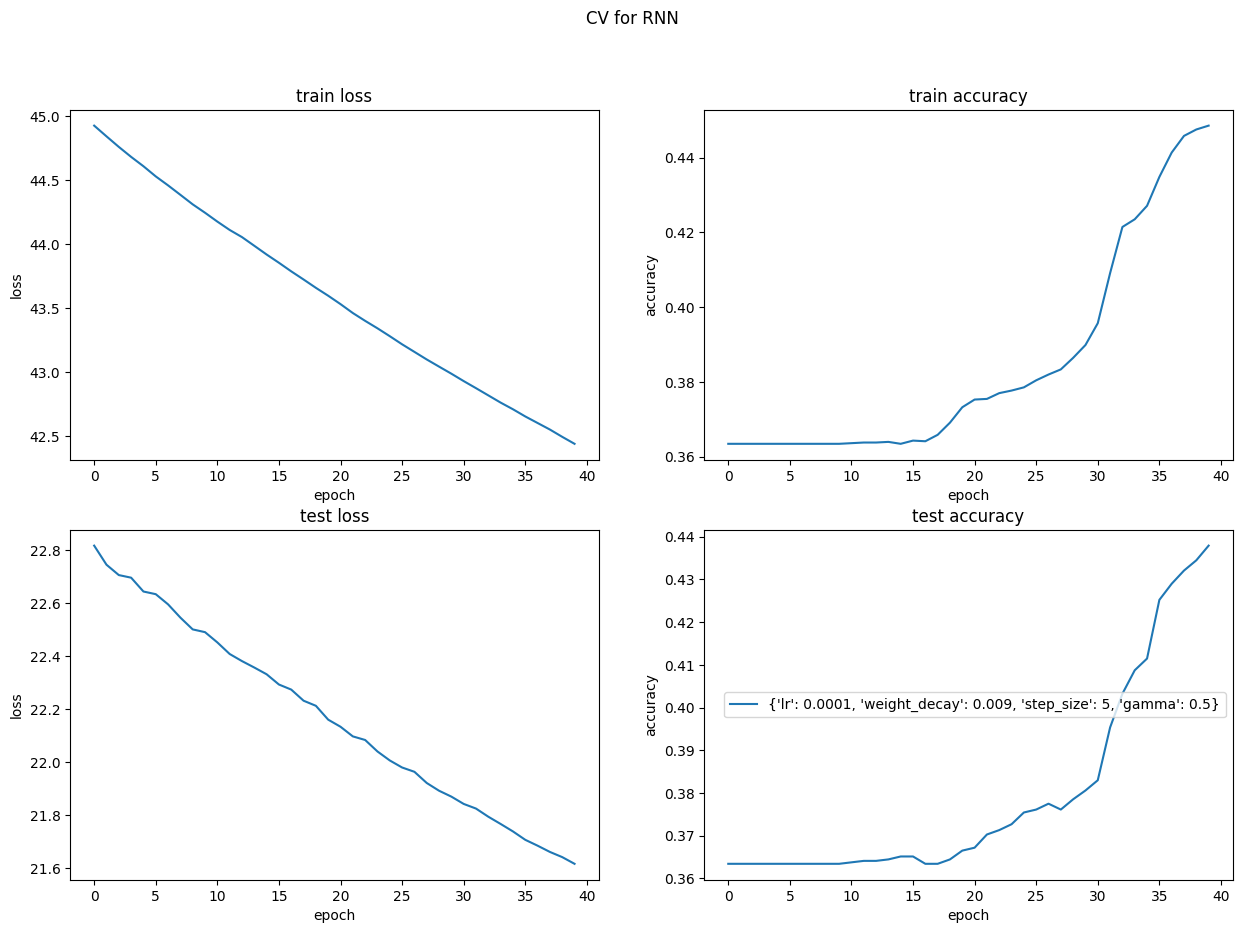

In [ ]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for RNN')

#### Training:

In [ ]:
from src.RNN_utils.trainer import trainer

model = viralCls(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.5)

train_model = trainer(model,criterion,optimizer,scheduler)

In [ ]:
results = train_model.train(train_dl, 50, True)

Train Batch: 100%|██████████| 92/92 [00:49<00:00,  1.87it/s]


Epoch #0: Loss - 60.964875876903534, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s]


Epoch #1: Loss - 60.423157036304474, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:50<00:00,  1.84it/s]


Epoch #2: Loss - 60.13418298959732, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:53<00:00,  1.72it/s]


Epoch #3: Loss - 60.00037455558777, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


Epoch #4: Loss - 59.96689349412918, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:49<00:00,  1.84it/s]


Epoch #5: Loss - 59.251351058483124, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.74it/s]


Epoch #6: Loss - 59.97588676214218, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:58<00:00,  1.58it/s]


Epoch #7: Loss - 59.71102350950241, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:56<00:00,  1.64it/s]


Epoch #8: Loss - 60.042579650878906, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:50<00:00,  1.83it/s]


Epoch #9: Loss - 58.92647331953049, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:52<00:00,  1.74it/s]


Epoch #10: Loss - 58.934528052806854, Accuracy - 0.6297185998627316


Train Batch: 100%|██████████| 92/92 [00:55<00:00,  1.66it/s]


Epoch #11: Loss - 58.69205057621002, Accuracy - 0.6365820178448868


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #12: Loss - 58.73748975992203, Accuracy - 0.651681537405628


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #13: Loss - 58.327474534511566, Accuracy - 0.6547700754975978


Train Batch: 100%|██████████| 92/92 [00:58<00:00,  1.58it/s]


Epoch #14: Loss - 58.0875568985939, Accuracy - 0.6564859299931366


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.39it/s]


Epoch #15: Loss - 57.870153307914734, Accuracy - 0.6650652024708305


Train Batch: 100%|██████████| 92/92 [01:01<00:00,  1.51it/s]


Epoch #16: Loss - 56.92665520310402, Accuracy - 0.6750171585449554


Train Batch: 100%|██████████| 92/92 [01:04<00:00,  1.43it/s]


Epoch #17: Loss - 57.117179811000824, Accuracy - 0.6650652024708305


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.38it/s]


Epoch #18: Loss - 56.90648704767227, Accuracy - 0.668496911461908


Train Batch: 100%|██████████| 92/92 [01:25<00:00,  1.07it/s]


Epoch #19: Loss - 57.1029235124588, Accuracy - 0.667124227865477


Train Batch: 100%|██████████| 92/92 [01:27<00:00,  1.05it/s]


Epoch #20: Loss - 55.18010175228119, Accuracy - 0.6976664378860673


Train Batch: 100%|██████████| 92/92 [01:24<00:00,  1.09it/s]


Epoch #21: Loss - 54.24480104446411, Accuracy - 0.7189430336307481


Train Batch: 100%|██████████| 92/92 [01:27<00:00,  1.05it/s]


Epoch #22: Loss - 52.08785858750343, Accuracy - 0.7378174330816747


Train Batch: 100%|██████████| 92/92 [01:14<00:00,  1.23it/s]


Epoch #23: Loss - 50.74869677424431, Accuracy - 0.7577213452299245


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #24: Loss - 49.168992817401886, Accuracy - 0.7769389155799589


Train Batch: 100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


Epoch #25: Loss - 48.24203506112099, Accuracy - 0.7855181880576527


Train Batch: 100%|██████████| 92/92 [01:06<00:00,  1.38it/s]


Epoch #26: Loss - 46.74368596076965, Accuracy - 0.8098833218943033


Train Batch: 100%|██████████| 92/92 [01:02<00:00,  1.47it/s]


Epoch #27: Loss - 46.004360258579254, Accuracy - 0.8088538091969801


Train Batch: 100%|██████████| 92/92 [01:07<00:00,  1.36it/s]


Epoch #28: Loss - 45.35944101214409, Accuracy - 0.8239533287577213


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #29: Loss - 43.895823538303375, Accuracy - 0.8400823610157858


Train Batch: 100%|██████████| 92/92 [01:46<00:00,  1.15s/it]


Epoch #30: Loss - 44.01968061923981, Accuracy - 0.8400823610157858


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #31: Loss - 43.564445823431015, Accuracy - 0.8428277282086479


Train Batch: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]


Epoch #32: Loss - 42.0831498503685, Accuracy - 0.86238846945779


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #33: Loss - 41.92361205816269, Accuracy - 0.8661633493479753


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #34: Loss - 41.62326240539551, Accuracy - 0.8665065202470831


Train Batch: 100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


Epoch #35: Loss - 40.008546620607376, Accuracy - 0.8846945778997941


Train Batch: 100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


Epoch #36: Loss - 39.41250318288803, Accuracy - 0.8901853122855182


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #37: Loss - 39.26542356610298, Accuracy - 0.893273850377488


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #38: Loss - 39.527875155210495, Accuracy - 0.8953328757721345


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #39: Loss - 39.03679233789444, Accuracy - 0.9049416609471517


Train Batch: 100%|██████████| 92/92 [01:18<00:00,  1.17it/s]


Epoch #40: Loss - 37.963591039180756, Accuracy - 0.9094028826355525


Train Batch: 100%|██████████| 92/92 [01:18<00:00,  1.17it/s]


Epoch #41: Loss - 36.87475794553757, Accuracy - 0.9217570350034318


Train Batch: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s]


Epoch #42: Loss - 36.56873497366905, Accuracy - 0.924159231297186


Train Batch: 100%|██████████| 92/92 [01:11<00:00,  1.29it/s]


Epoch #43: Loss - 36.49076610803604, Accuracy - 0.926904598490048


Train Batch: 100%|██████████| 92/92 [01:14<00:00,  1.24it/s]


Epoch #44: Loss - 36.15938702225685, Accuracy - 0.9293067947838023


Train Batch: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s]


Epoch #45: Loss - 36.097174137830734, Accuracy - 0.9296499656829101


Train Batch: 100%|██████████| 92/92 [01:13<00:00,  1.24it/s]


Epoch #46: Loss - 36.47840404510498, Accuracy - 0.9299931365820179


Train Batch: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


Epoch #47: Loss - 35.83904209733009, Accuracy - 0.9299931365820179


Train Batch: 100%|██████████| 92/92 [01:22<00:00,  1.11it/s]


Epoch #48: Loss - 35.774996131658554, Accuracy - 0.9289636238846946


Train Batch: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s]

Epoch #49: Loss - 35.697693794965744, Accuracy - 0.9337680164722032


In [ ]:
train_model.evaluate(val_dl)

Test Batch: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]


(15.972053527832031, 0.5967078189300411)